#Assignment: Robot Task Optimization Using Genetic Algorithm
### Name : Maherun Nessa Isty
### ID : 2021-2-60-086
### CSE366 : Artificial Intelligence (AI)
### Sec: 3


**Objective:**
The goal of this assignment is to develop and implement a Genetic Algorithm (GA) to optimize the
assignment of multiple robots to a set of tasks in a dynamic production environment. Your primary
objectives are to minimize the total production time, ensure a balanced workload across robots, and
prioritize critical tasks effectively. Additionally, you will create a detailed visualization to illustrate the final
task assignments, robot efficiencies, and task priorities.

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches


#Generating Mock data

In [ ]:
def generate_mock_data(num_tasks, num_robots):
    task_durations = np.random.randint(1, 11, size=num_tasks)
    task_priorities = np.random.randint(1, 6, size=num_tasks)
    robot_efficiencies = np.random.uniform(0.5, 1.5, size=num_robots)
    return task_durations, task_priorities, robot_efficiencies

#Fitness Function
By minimizing the total production time and keeping the workload balance low, the function aims to achieve an optimal solution where tasks are allocated efficiently among robots, critical tasks are prioritized, and the workload is evenly distributed.

In [ ]:
def total_production_time(tasks, priorities, efficiencies):
    total_time_per_robot = []
    for robot in range(len(efficiencies)):
        total_time = 0
        for task, priority in zip(tasks, priorities):         #the function iterates over the tasks and their corresponding priorities using the zip function, which combines elements from multiple iterables into tuples.
            total_time += (task * priority) / efficiencies[robot]
        total_time_per_robot.append(total_time)
    return max(total_time_per_robot)

def workload_balance(total_times):
    return np.std(total_times)

def fitness_function(tasks, priorities, efficiencies, solution):
    Ttotal = total_production_time(tasks, priorities, efficiencies)
    B = workload_balance([Ttotal])  # Pass a list to np.std
    F = Ttotal + B
    return F


##Selection, Crossover, and Mutation

In [ ]:
def tournament_selection(population, fitness_values, tournament_size):
    selected_parents = []
    num_individuals = len(population)
    for _ in range(num_individuals):
        tournament_candidates = np.random.choice(num_individuals, size=tournament_size, replace=False)
        tournament_fitness = fitness_values[tournament_candidates]
        winner_idx = np.argmax(tournament_fitness)
        selected_parents.append(population[tournament_candidates[winner_idx]])
    return np.array(selected_parents)

def crossover(parents, population_size):
    offsprings = []
    for _ in range(population_size):
        parent1_idx = np.random.randint(len(parents))
        parent2_idx = np.random.randint(len(parents))
        crossover_point = np.random.randint(1, len(parents[0]))  # Random crossover point
        offspring = np.empty_like(parents[0])  # Empty array for the offspring
        # Perform single-point crossover
        #offspring = np.concatenate((parents[parent1_idx][:crossover_point], parents[parent2_idx][crossover_point:]))
        offspring[:crossover_point] = parents[parent1_idx][:crossover_point]
        offspring[crossover_point:] = parents[parent2_idx][crossover_point:]
        offsprings.append(offspring)
    return np.array(offsprings)



def mutation(offspring_population, mutation_rate, num_robots):
    for offspring in offspring_population:
        for i in range(len(offspring)):
            if np.random.rand() < mutation_rate:
                offspring[i] = np.random.randint(num_robots)
    return offspring_population

#Genetic Algorithm

In [ ]:
def run_genetic_algorithm(task_durations, task_priorities, robot_efficiencies):

   # num_tasks = len(task_durations)
   # num_robots = len(robot_efficiencies)
    population_size = 50
    mutation_rate = 0.05
    num_generations = 100
    tournament_size=5             #how many individuals will compete in each tournament
    best_fitness = float('inf')

    #population = [generate_random_permutation(N, len(robot_efficiencies)) for _ in range(population_size)]
    population = [np.random.randint(0, len(robot_efficiencies), size=len(task_durations)) for _ in range(population_size)]

    for generation in range(num_generations):
        fitness_values = np.array([fitness_function(task_durations, task_priorities, robot_efficiencies, solution) for solution in population])
        if min(fitness_values) < best_fitness:
            best_solution = population[np.argmin(fitness_values)]
            best_fitness = min(fitness_values)
        selected_parents = tournament_selection(population, fitness_values, tournament_size)
        offsprings = crossover(selected_parents, population_size)
        offsprings = mutation(offsprings, mutation_rate, len(robot_efficiencies))
        population = offsprings
    return best_solution

#visualization

In [ ]:
def visualize_assignments_improved(solution, task_durations, task_priorities, robot_efficiencies, best_solution=None):
    # Create a grid for visualization based on the solution provided
    grid = np.zeros((len(robot_efficiencies), len(task_durations)), dtype=float)  # Initialize with float dtype

    # Create a list to store the priority values for each task
    task_priority_values = [task_priorities[task_idx] for task_idx in range(len(task_durations))]

    for task_idx, robot_idx in enumerate(solution):
        # Store duration in grid
        grid[robot_idx, task_idx] = task_durations[task_idx]

    fig, ax = plt.subplots(figsize=(12, 6))
    cmap = mcolors.LinearSegmentedColormap.from_list("", ["white", "blue"])  # Custom colormap

    # Display the grid with task durations
    cax = ax.matshow(grid, cmap=cmap)
    fig.colorbar(cax, label='Task Duration (hours)')

    # Set tick positions to be at the center of each cell
    ax.set_xticks(np.arange(len(task_durations)) - 0.5, minor=True)
    ax.set_yticks(np.arange(len(robot_efficiencies)) - 0.5, minor=True)
    ax.grid(which='minor', color='black', linestyle='-', linewidth=1.5)

    # Annotate each cell with task priority and duration
    for i in range(len(robot_efficiencies)):
        for j in range(len(task_durations)):
            cell_content = grid[i, j]
            if cell_content != 0:
                duration = int(cell_content)
                annotation = f'P{task_priority_values[j]}\n{duration}h'  # Use the same priority value for the entire column
                if best_solution is not None and (i, j) == (best_solution[j], j):
                    ax.text(j, i, annotation, ha='center', va='center', color='white', fontweight='bold')
                else:
                    ax.text(j, i, annotation, ha='center', va='center', color='black')
            else:
                # Annotate empty cells with corresponding priority and duration
                empty_duration = task_durations[j]
                empty_annotation = f'P{task_priority_values[j]}\n{empty_duration}h'  # Use the same priority value for the entire column
                ax.text(j, i, empty_annotation, ha='center', va='center', color='black')

    # Set the ticks and labels for tasks and robots
    ax.set_xticks(np.arange(len(task_durations)))
    ax.set_yticks(np.arange(len(robot_efficiencies)))
    ax.set_xticklabels([f'Task {i+1}' for i in range(len(task_durations))], rotation=45, ha="left")
    ax.set_yticklabels([f'Robot {i+1} (Efficiency: {eff:.2f})' for i, eff in enumerate(robot_efficiencies)])

    plt.xlabel('Tasks')
    plt.ylabel('Robots')
    plt.title('Task Assignments with Task Duration and Priority')

    # Create a legend for task priorities
    priority_patches = [mpatches.Patch(color='white', label=f'Priority {i}') for i in range(1, 6)]
    plt.legend(handles=priority_patches, bbox_to_anchor=(1.20, 1), loc='upper left', title="Task Priorities")

    plt.tight_layout()
    plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_total_working_hours(solution, task_durations, task_priorities, robot_efficiencies):
    # Calculate total working hours for each robot
    total_hours_per_robot = np.zeros(len(robot_efficiencies))
    for task_idx, robot_idx in enumerate(solution):
        total_hours_per_robot[robot_idx] += task_durations[task_idx] * task_priorities[task_idx] / robot_efficiencies[robot_idx]

    # Create a bar plot
    fig, ax = plt.subplots(figsize=(10, 6))
    robots = np.arange(len(robot_efficiencies))
    ax.bar(robots, total_hours_per_robot, color='blue')

    # Add labels and title
    ax.set_xlabel('Robots')
    ax.set_ylabel('Total Working Hours')
    ax.set_title('Total Working Hours for Each Robot')
    ax.set_xticks(robots)
    ax.set_xticklabels([f'Robot {i+1}' for i in range(len(robot_efficiencies))])

    plt.show()


In [ ]:
num_tasks = 10
num_robots = 5
task_durations, task_priorities, robot_efficiencies = generate_mock_data(num_tasks, num_robots)

# Run GA to find the best solution
best_solution = run_genetic_algorithm(task_durations, task_priorities, robot_efficiencies)

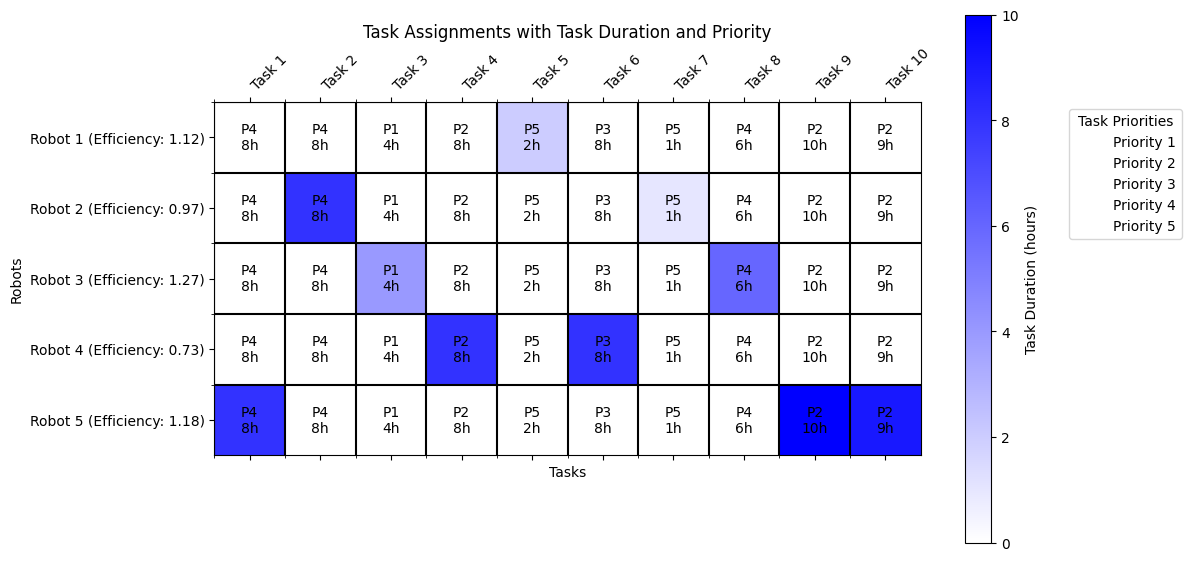

In [ ]:
# Visualize the initial random assignment
visualize_assignments_improved(best_solution, task_durations, task_priorities, robot_efficiencies)

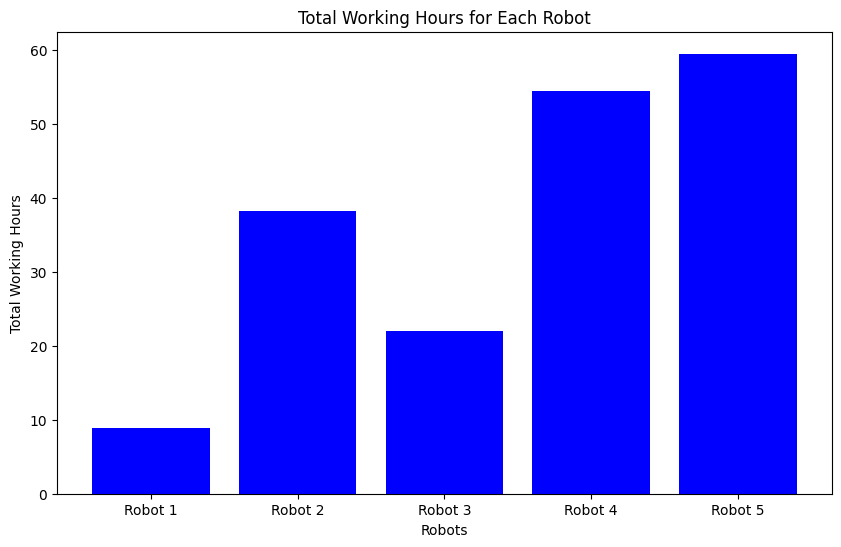

In [ ]:

# Plot the total working hours for each robot
plot_total_working_hours(best_solution, task_durations, task_priorities, robot_efficiencies)
